In [1]:
# Importem llibreries
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ruta de les dades de trànsit
folder_path = Path("/Users/guillemlopezcolomer/Desktop/TFG/traffic-prediction-tfg/data/Estat_transit")

# Fitxers csv
csv_files = sorted(folder_path.glob("*.csv"))

# Els llegeix i els concatena
df_list = []
for f in csv_files:
    try:
        df = pd.read_csv(f, on_bad_lines='warn')
        df["source_file"] = f.name
        df_list.append(df)
    except Exception as e:
        print(f"Error llegint {f.name}: {e}")

df = pd.concat(df_list, ignore_index=True)

/var/folders/83/gt48b8vj7tbdkb4w2zf5n42m0000gn/T/ipykernel_9382/2985880895.py:11: ParserWarning: Skipping line 2938804: expected 4 fields, saw 5

  df = pd.read_csv(f, on_bad_lines='warn')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243909993 entries, 0 to 243909992
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   idTram        int64 
 1   data          int64 
 2   estatActual   int64 
 3   estatPrevist  int64 
 4   source_file   object
dtypes: int64(4), object(1)
memory usage: 9.1+ GB


Corregim la variable data per tal que el seu tipus sigui datetime en comptes d'integer.

In [6]:
# Format de la data
df["data"] = pd.to_datetime(df["data"], format="%Y%m%d%H%M%S", errors='coerce')


In [9]:
print("Valors nuls per columna:\n", df.isnull().mean()*100)

Valors nuls per columna:
 idTram          0.0
data            0.0
estatActual     0.0
estatPrevist    0.0
source_file     0.0
dtype: float64


No tenim valors nuls en cap columna?

In [12]:
import duckdb

# Ruta al directori amb els fitxers
carpeta_csv = "/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/"

# Consulta tots els fitxers CSV dins la carpeta, sense carregar-los en RAM
query = f"""
SELECT * 
FROM read_csv_auto('{carpeta_csv}*.csv', AUTO_DETECT=TRUE)
LIMIT 10
"""

# Executa i mostra resultats
resultats = duckdb.query(query).to_df()
print(resultats)


   idTram            data  estatActual  estatPrevist
0       1  20171001002055            1             1
1       2  20171001002055            1             1
2       3  20171001002055            0             0
3       4  20171001002055            2             2
4       5  20171001002055            1             1
5       6  20171001002055            1             1
6       7  20171001002055            1             1
7       8  20171001002055            1             1
8       9  20171001002055            1             1
9      10  20171001002055            1             1


In [19]:
query = f"""
SELECT 
    idTram, 
    COUNT(*) AS num_files, 
    AVG(estatActual) AS mitjana_estat
FROM read_csv_auto('{carpeta_csv}*_TRAMS_TRAMS.csv')
WHERE data > 202101010000 AND data < 202101312359
GROUP BY idTram
ORDER BY mitjana_estat DESC
LIMIT 10
"""
resultats = duckdb.query(query).to_df()
print(resultats)


Empty DataFrame
Columns: [idTram, num_files, mitjana_estat]
Index: []


In [17]:
query = f"""
SELECT COUNT(*) AS num_files
FROM read_csv_auto('{carpeta_csv}*_TRAMS_TRAMS.csv', 
                   AUTO_DETECT=TRUE, 
                   IGNORE_ERRORS=TRUE)
"""
duckdb.query(query).to_df()


,num_files
0,243909994


In [20]:
import glob
import os

fitxers = glob.glob(os.path.join(carpeta_csv, "*_TRAMS_TRAMS.csv"))
print(f"{len(fitxers)} fitxers trobats:")
print(fitxers[:5])

78 fitxers trobats:
['/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/2022_08_Agost_TRAMS_TRAMS.csv', '/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/2022_12_Desembre_TRAMS_TRAMS.csv', '/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/2023_06_Juny_TRAMS_TRAMS.csv', '/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/2024_04_Abril_TRAMS_TRAMS.csv', '/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/2018_05_Maig_TRAMS_TRAMS.csv']


In [21]:
df_test = duckdb.query(f"""
SELECT * 
FROM read_csv_auto('{carpeta_csv}*_TRAMS_TRAMS.csv', 
                   AUTO_DETECT=TRUE, 
                   IGNORE_ERRORS=TRUE)
LIMIT 5
""").to_df()

print(df_test)


   idTram            data  estatActual  estatPrevist
0       1  20171001002055            1             1
1       2  20171001002055            1             1
2       3  20171001002055            0             0
3       4  20171001002055            2             2
4       5  20171001002055            1             1


In [22]:
duckdb.query(f"""
SELECT * 
FROM read_csv_auto('{carpeta_csv}*_TRAMS_TRAMS.csv', 
                   AUTO_DETECT=TRUE, 
                   IGNORE_ERRORS=TRUE)
LIMIT 1
""").df().columns


Index(['idTram', 'data', 'estatActual', 'estatPrevist'], dtype='object')

In [26]:
duckdb.query(f"""
SELECT 
    idTram,
    COUNT(*) AS num_files,
    AVG(estatActual) AS mitjana_estat
FROM read_csv_auto('{carpeta_csv}*_TRAMS_TRAMS.csv', 
                   AUTO_DETECT=TRUE, 
                   IGNORE_ERRORS=TRUE)
WHERE estatActual not in (0,6)
GROUP BY idTram
ORDER BY mitjana_estat DESC
LIMIT 10
""").to_df()


,idTram,num_files,mitjana_estat
0,453,27020,4.246817
1,22,326706,2.966615
2,2003,12,2.833333
3,83,319801,2.806154
4,445,310381,2.759496
5,58,309438,2.756003
6,57,309411,2.755852
7,96,15249,2.683258
8,538,123519,2.676277
9,132,367183,2.657323


In [28]:
import pandas as pd

query = f"""
SELECT DISTINCT 
    SUBSTR(CAST(data AS VARCHAR), 1, 8) AS dia
FROM read_csv_auto('{carpeta_csv}*_TRAMS_TRAMS.csv', 
                   AUTO_DETECT=TRUE, 
                   IGNORE_ERRORS=TRUE)
"""
dies_present = duckdb.query(query).to_df()
dies_present["dia"] = pd.to_datetime(dies_present["dia"], format="%Y%m%d")


In [29]:
dates_totals = pd.date_range(start="2017-10-01", end="2025-02-28", freq="D")

In [31]:
dates_falten = dates_totals[~dates_totals.isin(dies_present["dia"])]
print(f"S'han detectat {len(dates_falten)} dies sense dades.")
print(dates_falten[:100])

S'han detectat 359 dies sense dades.
DatetimeIndex(['2019-07-01', '2019-07-02', '2019-07-03', '2019-07-04',
               '2019-07-05', '2019-07-06', '2019-07-07', '2019-07-08',
               '2019-07-09', '2019-07-10', '2019-07-11', '2019-07-12',
               '2019-07-13', '2019-07-14', '2019-07-15', '2019-07-16',
               '2019-07-17', '2019-07-18', '2019-07-19', '2019-07-20',
               '2019-07-21', '2019-07-22', '2019-07-23', '2019-07-24',
               '2019-07-25', '2019-07-26', '2019-07-27', '2019-07-28',
               '2019-07-29', '2019-07-30', '2019-07-31', '2019-09-01',
               '2019-09-02', '2019-09-03', '2019-09-04', '2019-09-05',
               '2019-09-06', '2019-09-07', '2019-09-08', '2019-09-09',
               '2019-09-10', '2019-09-11', '2019-09-12', '2019-09-13',
               '2019-09-14', '2019-09-15', '2019-09-16', '2019-09-17',
               '2019-09-18', '2019-09-19', '2019-09-20', '2019-09-21',
               '2019-09-22', '2019-09-23

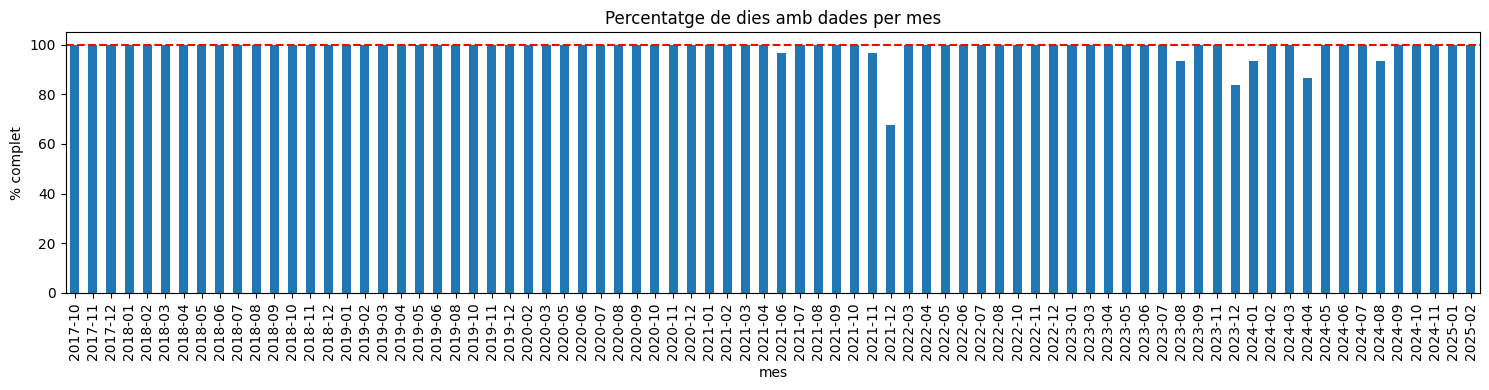

In [32]:
dies_present["mes"] = dies_present["dia"].dt.to_period("M")
presencia_per_mes = dies_present.groupby("mes").size().reset_index(name="dies_present")

# Compara amb dies totals per mes
from pandas.tseries.offsets import MonthEnd
presencia_per_mes["dies_mes"] = presencia_per_mes["mes"].apply(lambda m: (m.to_timestamp() + MonthEnd(0)).day)
presencia_per_mes["percentatge_complet"] = presencia_per_mes["dies_present"] / presencia_per_mes["dies_mes"] * 100

import matplotlib.pyplot as plt
presencia_per_mes.set_index("mes")["percentatge_complet"].plot(kind="bar", figsize=(15, 4))
plt.axhline(100, color="red", linestyle="--")
plt.title("Percentatge de dies amb dades per mes")
plt.ylabel("% complet")
plt.tight_layout()
plt.show()
